In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn.metrics

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.stats.multicomp as mc

from statannotations.Annotator import Annotator

In [2]:
mpl.rcParams.update({'xtick.labelsize': 14, 'ytick.labelsize': 14, 
                     'axes.titlesize':14, 'axes.labelsize':16}) #default font sizes for plots

In [3]:
data_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/MLM/agarwal_2022/'

In [4]:
BC3MS_MLM = pd.read_csv(data_dir + 'MLM/BC3MS_mll.tsv', sep = '\t')#BC3MS model with MLM embeddings for 3'UTR 

In [5]:
BC3MS_MLM

,fold,r2_svr,pearson_r_svr,r2_lasso,pearson_r_lasso,C,epsilon,gamma
0,0,0.430968,0.663224,0.449636,0.675120,15.508154,0.747797,0.000208
1,1,0.447593,0.669105,0.451599,0.672128,15.508154,0.747797,0.000208
2,2,0.484417,0.696114,0.497078,0.705347,15.508154,0.747797,0.000208
3,3,0.445446,0.668597,0.442885,0.667111,15.508154,0.747797,0.000208
4,4,0.480242,0.693931,0.485376,0.698034,15.508154,0.747797,0.000208
5,5,0.471954,0.688358,0.471990,0.688764,15.508154,0.747797,0.000208
6,6,0.444838,0.667285,0.457723,0.676566,15.508154,0.747797,0.000208
7,7,0.444967,0.667994,0.447951,0.670362,15.508154,0.747797,0.000208
8,8,0.437922,0.666131,0.446664,0.671389,15.508154,0.747797,0.000208
9,9,0.457714,0.677628,0.464899,0.683406,15.508154,0.747797,0.000208


In [6]:
BC3MS_MLM = BC3MS_MLM.pearson_r_svr.rename('BC3MS(MLM)') 

In [7]:
per_fold_scores = pd.read_csv(data_dir + 'saluki_paper/Fig5_S6/experimentResults.csv')

In [8]:
per_fold_scores = pd.concat([per_fold_scores, BC3MS_MLM],axis=1)

In [9]:
per_fold_scores = per_fold_scores[['BC3MS','BC3MS(MLM)','Saluki human']]

In [10]:
per_fold_scores = per_fold_scores.apply(lambda x:[list(x)]).T.rename(columns={0:'score'}).explode('score')

In [11]:
per_fold_scores = per_fold_scores.reset_index(names='model')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

BC3MS vs. BC3MS(MLM): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:7.695e-01 Stat=2.400e+01


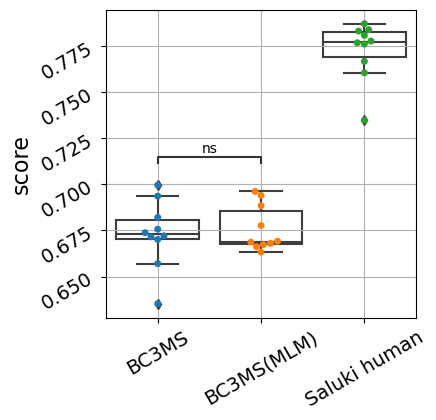

In [89]:
fig, ax = plt.subplots(figsize=(4,4))

ax = sns.swarmplot(data=per_fold_scores, x="model", y="score") #scatter plot
ax = sns.boxplot(data=per_fold_scores, x="model", y="score", boxprops={'facecolor':'None'})

box_pairs=[ ('BC3MS', 'BC3MS(MLM)'), ]

annotator = Annotator(ax, box_pairs, data=per_fold_scores, x="model", y="score")
annotator.configure(test='Wilcoxon', text_format='star', loc='inside', comparisons_correction="BH")
#annotator.configure(test='t-test_paired', text_format='star', loc='inside', comparisons_correction="BH")

annotator.apply_and_annotate()

ax.set_xlabel("")
ax.set_ylabel("score")
ax.tick_params(rotation=30)
ax.grid()

In [85]:
per_fold_scores.groupby('model').score.mean()

model
BC3MS           0.673041
BC3MS(MLM)      0.675837
Saluki human     0.77264
Name: score, dtype: object

In [34]:
from scipy.stats import t

df = 10-1 #number of folds minus 1

def get_ci_95(x):
    
    ci_95 = t.interval(0.95, df, loc=np.mean(x), scale=np.std(x))
    return np.mean(x), np.diff(ci_95)[0]/2

In [36]:
per_fold_scores.groupby('model').score.apply(lambda x:get_ci_95(x)).apply(lambda x: f'{x[0]:.2f}±{x[1]:.2f}').reset_index()

,model,score
0,BC3MS,0.67±0.04
1,BC3MS(MLM),0.68±0.03
2,Saluki human,0.77±0.03
